In [2]:
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import bayesian_blocks

from scipy.stats import ks_2samp
import scipy.stats as ss

import numpy as np

from vast.voidfinder.distance import z_to_comoving_dist

import matplotlib.pyplot as plt

In [3]:
# Kgals = Table.read('/home/codebind/Bootes/KOSS87.csv', format='ascii.csv')
# Kgals['dis'] = z_to_comoving_dist(np.array(Kgals['Redshift'],dtype=np.float32),0.315,1)
# Kgals.remove_column('Object Name')
# Kgals.sort('No.')
KNSA = Table.read('KNSA.txt', format = 'ascii.commented_header')
nsa = Table.read('/home/codebind/Bootes/NSA_Full.fits', format = 'fits')

In [4]:
catalog_SDSS = nsa[nsa['IN_DR7_LSS'] == 1]
del nsa

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]
del catalog_SDSS

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])

catalog_main = catalog_north[~strip_boolean]
del catalog_north

In [5]:
NSA = Table()
NSA['INDEX'] = catalog_main['index']
NSA['IAUNAME'] = catalog_main['IAUNAME']
NSA['RA'] = catalog_main['RA']
NSA['DEC'] = catalog_main['DEC']
NSA['Z'] = catalog_main['Z']
NSA['DIST'] = z_to_comoving_dist(np.array(catalog_main['Z'],dtype=np.float32),0.315,1)
NSA['MASS'] = catalog_main['ELPETRO_MASS']
NSA['SFR'] = catalog_main['SFR']
NSA['base_SFR'] = 10**NSA['SFR']
NSA['sSFR'] = catalog_main['sSFR']
NSA['base_sSFR'] = 10**NSA['sSFR']
NSA['ABSMAG'] = catalog_main['ELPETRO_ABSMAG'][:,4]
NSA['U-R'] = catalog_main['u_r']
del catalog_main

In [6]:
NSA = NSA[NSA['Z']>0 & np.isfinite(NSA['U-R'])]

In [6]:
# kra = Kgals['RA'] * u.deg
# kdec = Kgals['DEC'] * u.deg
# kdist = (Kgals['dis'] * u.Mpc).to(u.m)
# KSC = SkyCoord(kra, kdec,kdist)

# nra = NSA['RA'] *u.deg
# ndec = NSA['DEC'] * u.deg
# ndist = (NSA['DIST'] * u.Mpc).to(u.m)
# NSC = SkyCoord(nra,ndec,ndist)

# indices, D2D, D3D = KSC.match_to_catalog_sky(NSC)

# Kgals['NSA_index'] = indices
# Kgals['2D Dist'] = D2D
# Kgals['3D Dist'] = D3D

NameError: name 'Kgals' is not defined

In [7]:
# KNSA = NSA[indices]
# KNSA.write('KNSA.txt', format= 'ascii.commented_header')

Text(0.5, 1.0, 'NSA vs KOSS87 Absolute Magnitude')

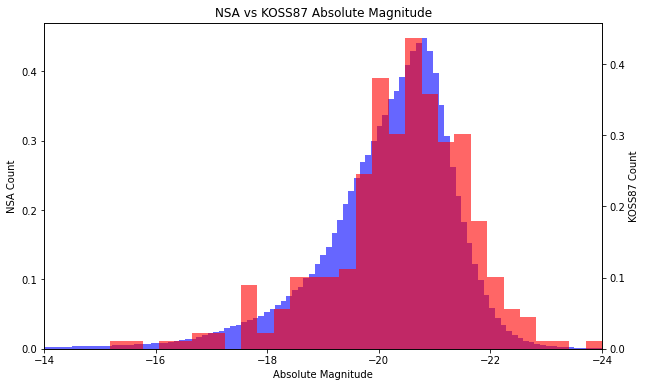

In [10]:
mag_bin = np.linspace(-24,-14,100)
# smallmag_bin = bayesian_blocks(KNSA['ABSMAG'], fitness='events', p0=1.3)
smallmag_bin = np.linspace(-24,-14,35)

mag_fig, nsa_ax = plt.subplots(figsize= (10,6))
knsa_ax = nsa_ax.twinx()

nsa_ax.hist(NSA['ABSMAG'], bins = mag_bin, color = 'blue', alpha = 0.6, density = True)
knsa_ax.hist(KNSA['ABSMAG'], bins = smallmag_bin, color = 'red', alpha = 0.6, density = True)

plt.xlim([-14,-24])
nsa_ax.set_xlabel('Absolute Magnitude')
nsa_ax.set_ylabel('NSA Count')
knsa_ax.set_ylabel('KOSS87 Count')
nsa_ax.set_title('NSA vs KOSS87 Absolute Magnitude')
# mag_fig.savefig('magnitude_hist.jpg', dpi = 120)

Text(0.5, 1.0, 'NSA vs KOSS87 Absolute Magnitude')

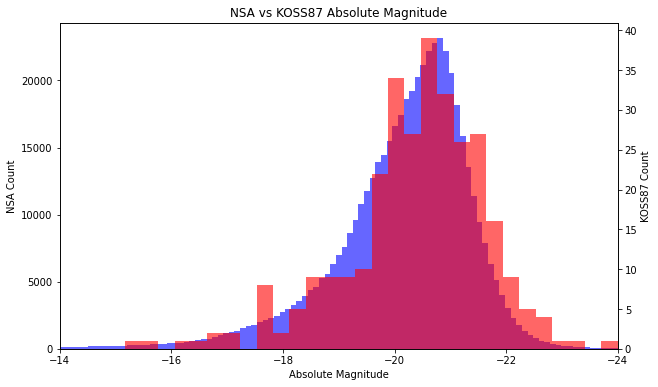

In [11]:
mag_bin = np.linspace(-24,-14,100)
# smallmag_bin = bayesian_blocks(KNSA['ABSMAG'], fitness='events', p0=1.3)
smallmag_bin = np.linspace(-24,-14,35)

mag_fig, nsa_ax = plt.subplots(figsize= (10,6))
knsa_ax = nsa_ax.twinx()

nsa_ax.hist(NSA['ABSMAG'], bins = mag_bin, color = 'blue', alpha = 0.6, density = False)
knsa_ax.hist(KNSA['ABSMAG'], bins = smallmag_bin, color = 'red', alpha = 0.6, density = False)

plt.xlim([-14,-24])
nsa_ax.set_xlabel('Absolute Magnitude')
nsa_ax.set_ylabel('NSA Count')
knsa_ax.set_ylabel('KOSS87 Count')
nsa_ax.set_title('NSA vs KOSS87 Absolute Magnitude')
# mag_fig.savefig('magnitude_hist.jpg', dpi = 120)

Text(0.5, 1.0, 'NSA vs KOSS87 u-r Spectrum')

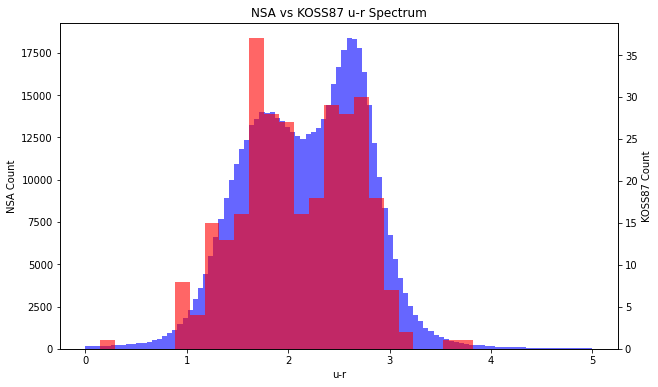

In [24]:
ur_bin = np.linspace(0, 5, 100)
# smallur_bin = bayesian_blocks(KNSA['U-R'], fitness = 'events', p0=1)
smallur_bin = np.linspace(0, 5, 35)
# np.hist to bin
# kde

ur_fig, nsa_ax = plt.subplots(figsize= (10,6))
knsa_ax = nsa_ax.twinx()

nsa_ax.hist(NSA['U-R'], bins = ur_bin, color = 'blue', alpha = 0.6)
knsa_ax.hist(KNSA['U-R'], bins = smallur_bin, color = 'red', alpha = 0.6)

nsa_ax.set_xlabel('u-r')
nsa_ax.set_ylabel('NSA Count')
knsa_ax.set_ylabel('KOSS87 Count')
nsa_ax.set_title('NSA vs KOSS87 u-r Spectrum')

# ur_fig.savefig('Spectrum_hist.jpg', dpi = 120)

Text(0.5, 1.0, 'NSA vs KOSS87 Star Formation Rate')

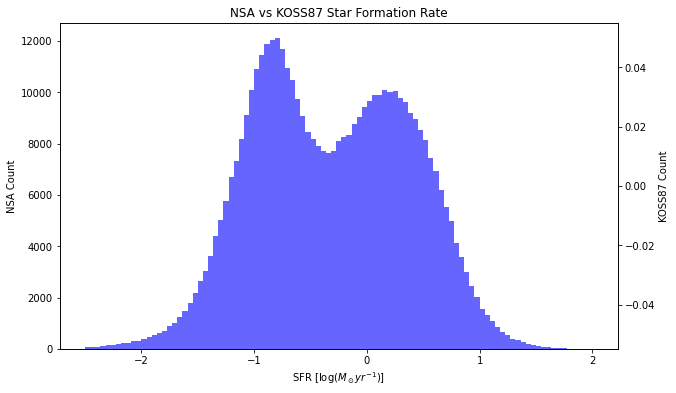

In [12]:
sfr_bin = np.linspace(-2.5, 2, 100)
# smallsfr_bin = bayesian_blocks(KNSA['SFR'], fitness = 'events', p0 = 0.1)
smallsfr_bin = np.linspace(-2.5, 2, 30)

sfr_fig, nsa_ax = plt.subplots(figsize= (10,6))
knsa_ax = nsa_ax.twinx()

nsa_ax.hist(NSA['SFR'], bins = sfr_bin, color = 'blue', alpha = 0.6)
knsa_ax.hist(KNSA['SFR'], bins = smallsfr_bin, color = 'red', alpha = 0.6)

nsa_ax.set(xlabel='SFR [log($M_\odot yr^{-1}$)]')
nsa_ax.set_ylabel('NSA Count')
knsa_ax.set_ylabel('KOSS87 Count')
nsa_ax.set_title('NSA vs KOSS87 Star Formation Rate')

# sfr_fig.savefig('SFR_hist.jpg', dpi = 120)

Text(0.5, 1.0, 'NSA vs KOSS87 Specific Star Formation Rate')

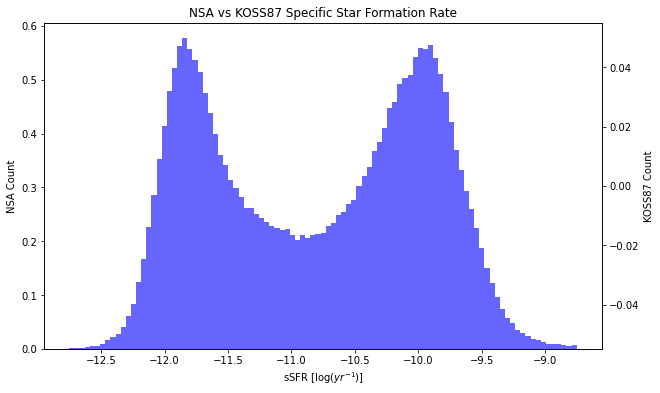

In [13]:
ssfr_bin = np.linspace(-12.75, -8.75, 100)
smallssfr_bin = bayesian_blocks(KNSA['sSFR'], fitness = 'events', p0 =0.1)
# smallssfr_bin = np.linspace(-12.75, -8.75, 50)

ssfr_fig, nsa_ax = plt.subplots(figsize= (10,6))
knsa_ax = nsa_ax.twinx()

nsa_ax.hist(NSA['sSFR'], bins = ssfr_bin, density=True, color = 'blue', alpha = 0.6)
knsa_ax.hist(KNSA['sSFR'], bins = smallssfr_bin, density=True, color = 'red', alpha = 0.6)

nsa_ax.set(xlabel='sSFR [log($yr^{-1}$)]')
nsa_ax.set_ylabel('NSA Count')
knsa_ax.set_ylabel('KOSS87 Count')
nsa_ax.set_title('NSA vs KOSS87 Specific Star Formation Rate')

# ssfr_fig.savefig('sSFR_hist.jpg', dpi = 120)

/tmp/ipykernel_4383/2388886798.py:8: RuntimeWarning: divide by zero encountered in log10
  nsa_ax.hist(np.log10(NSA['MASS']), bins = mass_bin, color = 'blue', alpha = 0.6)


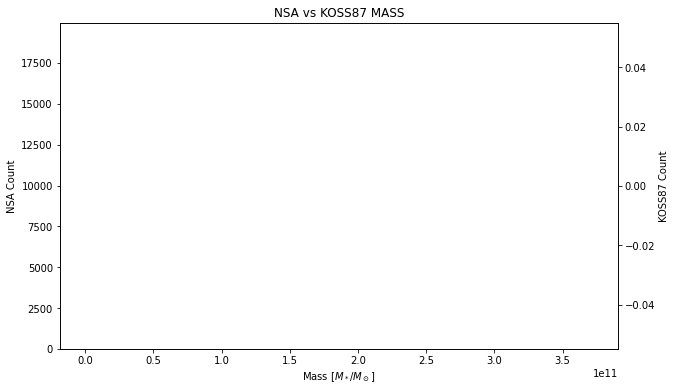

In [15]:
mass_bin = np.linspace(8, 12, 100)
smallmass_bin = bayesian_blocks(KNSA['MASS'], fitness = 'events', p0 = .1)
# smallmass_bin = np.linspace(8, 12, 50)

mass_fig, nsa_ax = plt.subplots(figsize= (10,6))
knsa_ax = nsa_ax.twinx()

nsa_ax.hist(np.log10(NSA['MASS']), bins = mass_bin, color = 'blue', alpha = 0.6)
knsa_ax.hist(np.log10(KNSA['MASS']), bins = smallmass_bin, color = 'red', alpha = 0.6)

nsa_ax.set(xlabel='Mass [$M_*/M_\odot$]')
nsa_ax.set_ylabel('NSA Count')
knsa_ax.set_ylabel('KOSS87 Count')
nsa_ax.set_title('NSA vs KOSS87 MASS')

fig = mass_fig
# fig.savefig('mass_hist.jpg', dpi = 120)

In [10]:
mag_test = ks_2samp(KNSA['ABSMAG'], NSA['ABSMAG'])
ur_test = ks_2samp(KNSA['U-R'], NSA['U-R'])
mass_test = ks_2samp(KNSA['MASS'], NSA['MASS'])
sfr_test = ks_2samp(KNSA['SFR'], NSA['SFR'])
ssfr_test = ks_2samp(KNSA['sSFR'], NSA['sSFR'])

In [11]:
print(mag_test)
print(ur_test)
print(mass_test)
print(sfr_test)
print(ssfr_test)

KstestResult(statistic=0.11067578982361528, pvalue=0.0010665888538301533)
KstestResult(statistic=0.08525088795692415, pvalue=0.02368754924528782)
KstestResult(statistic=0.08278761904947052, pvalue=0.02923004879225799)
KstestResult(statistic=0.04790232940003389, pvalue=0.6151895729580076)
KstestResult(statistic=0.09044254210655941, pvalue=0.03521480333624161)


Text(0.5, 1.0, 'Absolute Magnitude CDF')

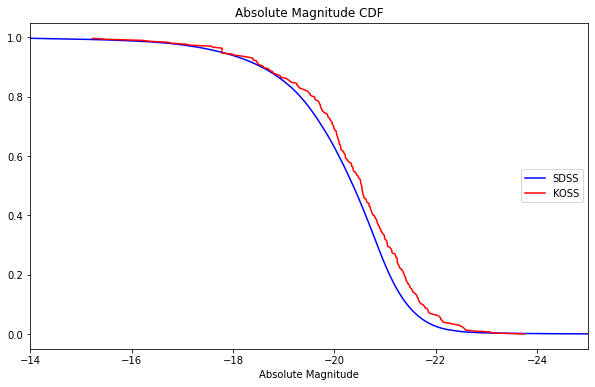

In [7]:
nN = len(NSA)
kN = len(KNSA)

nabsx = np.sort(NSA['ABSMAG'])
kabsx = np.sort(KNSA['ABSMAG'])

ny = np.arange(nN) / float(nN)
ky = np.arange(kN) / float(kN)

fig, ax = plt.subplots(figsize= (10,6))
ax.plot(nabsx, ny, color = 'blue', label = 'SDSS')
ax.plot(kabsx,ky, color = 'red', label = 'KOSS')
ax.legend(loc = 'right')
plt.xlim([-14,-25])
plt.xlabel('Absolute Magnitude')
plt.title('Absolute Magnitude CDF')

Text(0.5, 1.0, 'Spectrum CDF')

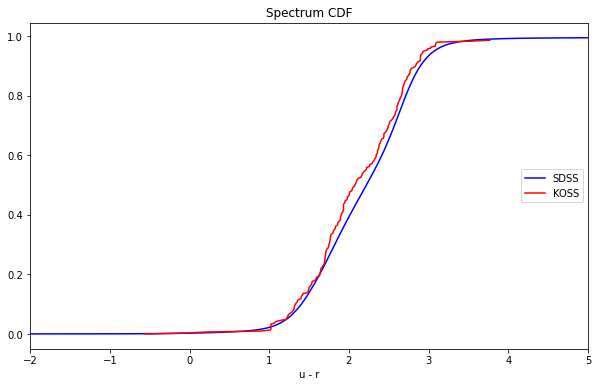

In [50]:
nN = len(NSA)
kN = len(KNSA)

nurx = np.sort(NSA['U-R'])
kurx = np.sort(KNSA['U-R'])

ny = np.arange(nN) / float(nN)
ky = np.arange(kN) / float(kN)

fig, ax = plt.subplots(figsize= (10,6))
ax.plot(nurx, ny, color = 'blue', label = 'SDSS')
ax.plot(kurx,ky, color = 'red', label = 'KOSS')
ax.legend(loc = 'right')
plt.xlim([-2,5])
plt.xlabel('u - r')
plt.title('Color CDF')

/tmp/ipykernel_4731/4112156914.py:4: RuntimeWarning: divide by zero encountered in log
  nmassx = np.sort(np.log(NSA['MASS']))


Text(0.5, 1.0, 'Stellar Mass CDF')

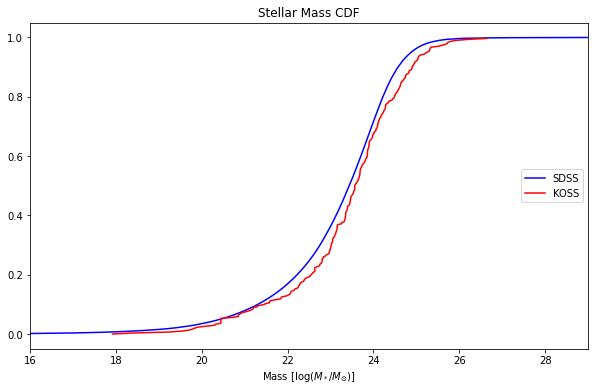

In [49]:
nN = len(NSA)
kN = len(KNSA)

nmassx = np.sort(np.log(NSA['MASS']))
kmassx = np.sort(np.log(KNSA['MASS']))

ny = np.arange(nN) / float(nN)
ky = np.arange(kN) / float(kN)

fig, ax = plt.subplots(figsize= (10,6))
ax.plot(nmassx, ny, color = 'blue', label = 'SDSS')
ax.plot(kmassx,ky, color = 'red', label = 'KOSS')
ax.legend(loc = 'right')
plt.xlim([16,29])
plt.xlabel('Mass [log($M_* / M_{\odot}$)]')
plt.title('Stellar Mass CDF')

Text(0.5, 1.0, 'Star Formation Rate CDF')

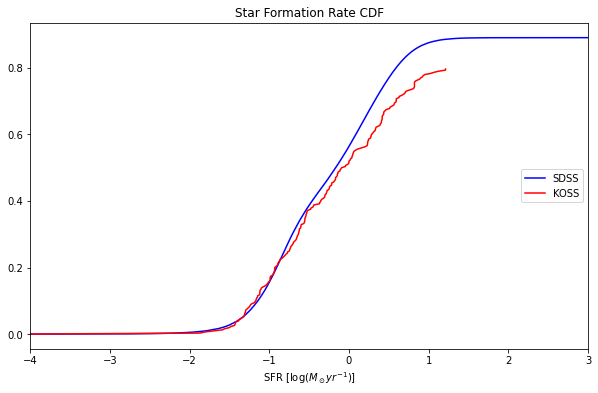

In [61]:
nN = len(NSA)
kN = len(KNSA)

nsfrx = np.sort(NSA['SFR'])
ksfrx = np.sort(KNSA['SFR'])

ny = np.arange(nN) / float(nN)
ky = np.arange(kN) / float(kN)

fig, ax = plt.subplots(figsize= (10,6))
ax.plot(nsfrx, ny, color = 'blue', label = 'SDSS')
ax.plot(ksfrx, ky, color = 'red', label = 'KOSS')
ax.legend(loc = 'right')
plt.xlim([-4,3])
plt.xlabel('SFR [log($M_\odot yr^{-1}$)]')
plt.title('Star Formation Rate CDF')

Text(0.5, 1.0, 'Specific Star Formation Rate CDF')

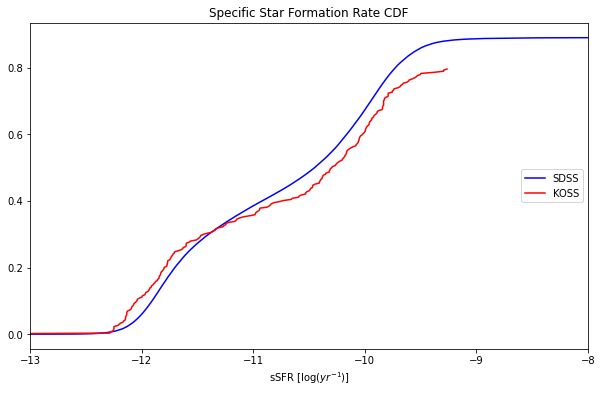

In [64]:
nN = len(NSA)
kN = len(KNSA)

nssfrx = np.sort(NSA['sSFR'])
kssfrx = np.sort(KNSA['sSFR'])

ny = np.arange(nN) / float(nN)
ky = np.arange(kN) / float(kN)

fig, ax = plt.subplots(figsize= (10,6))
ax.plot(nssfrx, ny, color = 'blue', label = 'SDSS')
ax.plot(kssfrx, ky, color = 'red', label = 'KOSS')
ax.legend(loc = 'right')
plt.xlim([-13,-8])
plt.xlabel('sSFR [log($yr^{-1}$)]')
plt.title('Specific Star Formation Rate CDF')